In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(lsmeans))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(export))
R.Version()

$platform
[1] "x86_64-apple-darwin15.6.0"

$arch
[1] "x86_64"

$os
[1] "darwin15.6.0"

$system
[1] "x86_64, darwin15.6.0"

$status
[1] ""

$major
[1] "3"

$minor
[1] "6.1"

$year
[1] "2019"

$month
[1] "07"

$day
[1] "05"

$`svn rev`
[1] "76782"

$language
[1] "R"

$version.string
[1] "R version 3.6.1 (2019-07-05)"

$nickname
[1] "Action of the Toes"

# Import data

## - Phenotypes

In [11]:
data <- read.csv("../data/fig2_table3.csv", header = T); 
data$vars <- factor(data$Treatment, levels = c("LFD", "HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN"))
data$vars2 <- factor(data$Treatment, levels = c("HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN", "LFD"))
data <- data %>% mutate(lv_tot_tag = (LV_TAG * liver_wt)/1000,
                        EE_norm = avgEE*1000/Lean_mass, 
                        fecal_tot_tag = TG_feces2*fecal_tot_output, 
                        kkcal = Cal_cum/1000,
                        uptake_f = uptake_freq_light + uptake_freq_dark,
                        allMeters = allmeters_light+allmeters_dark,
                        allPeds = pedmeters_light+pedmeters_dark); head(data)
txn <- data %>% filter(vars2 == "HFD+TXN"); hfd <- data %>% filter(vars2 == "HFD");
lxn <- data %>% filter(vars2 == "HFD+LXN"); hxn <- data %>% filter(vars2 == "HFD+HXN");
lfd <- data %>% filter(vars2 == "LFD")

,ID,Treatment,Cal_cum,LV_TAG,lipidosis_area_pct,Fat_mass,subq_wt,epi_wat,mesenteric_wt,plasma_TAG,⋯,pedmeters_dark,vars,vars2,lv_tot_tag,EE_norm,fecal_tot_tag,kkcal,uptake_f,allMeters,allPeds
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,1,LFD,1425.870,367.77,17.596,11.152,0.40,1.80,0.33,38.547,⋯,146.4725,LFD,LFD,0.5810766,22.21568,17.55000,1.425870,23,227.4935,190.1555
2,2,LFD,1241.231,400.53,0.696,7.357,0.72,1.34,0.48,53.408,⋯,195.6513,LFD,LFD,0.5126784,21.79943,15.02280,1.241231,26,267.6345,227.4692
3,3,LFD,1298.180,379.47,17.311,10.517,0.89,2.08,0.94,68.087,⋯,186.3535,LFD,LFD,0.5236686,28.79635,13.38480,1.298180,23,251.1943,212.1898
4,4,LFD,1812.026,332.67,16.353,12.781,0.78,2.13,0.54,37.492,⋯,136.4208,LFD,LFD,0.6520332,30.11525,20.70900,1.812026,34,295.1175,237.1283
5,5,LFD,1373.638,408.33,5.164,6.385,0.26,0.97,0.32,46.053,⋯,195.0978,LFD,LFD,0.5634954,22.49855,17.52855,1.373638,29,262.2310,231.9523
6,6,LFD,1448.174,454.35,22.362,11.460,0.99,2.07,0.60,45.932,⋯,115.4911,LFD,LFD,0.7224165,25.35729,7.85460,1.448174,50,234.2913,177.0421


# Set theme, import functions

In [12]:
theme_set(theme_bw())

In [13]:
theme_legend2 = function(){
	theme(axis.title.y = element_text(size = 15, 
	margin = margin(t=0, r=5, b=0, l=5)),
	axis.text.y = element_text(size = 13),
	axis.text.x = element_text(size = 13),
	axis.title.x = element_text(size = 15,
                               margin = margin(t=10, r=5, b=0, l=0)),
    plot.title = element_text(size = 15, face = "bold"),
	legend.title = element_text(colour = "white"),
	legend.text = element_text(size = 16),
	legend.position = "none",
	plot.margin = unit(c(0.5,0.5,0,0.5), "cm"),
	panel.grid = element_blank())
}

In [14]:
source("../src/ggplotRegression.R")

In [15]:
mycolor <- c("#0080ff", "#ffa500", "red", "darkgreen", "black")
mycolor_alpha <- c("#8AB5F9", "#F8CB89", "#F08581", "#87A57E", "#797979")

In [16]:
Contrasts <- list(
    'LFD vs HFD' = c(-1, 0, 0, 0, 1),
    'LXN vs HFD' = c(-1, 1, 0, 0, 0),
    'HXN vs HFD' = c(-1, 0, 1, 0, 0),
    'TXN vs HFD' = c(-1, 0, 0, 1, 0))

# Figures

In [8]:
names(data)

[1] "ID"                 "Treatment"          "Cal_cum"           
 [4] "LV_TAG"             "lipidosis_area_pct" "Fat_mass"          
 [7] "subq_wt"            "epi_wat"            "mesenteric_wt"     
[10] "plasma_TAG"         "liver_wt"           "TG_feces"          
[13] "TG_feces2"          "fecal_tot_output"   "wt"                
[16] "Lean_mass"          "avgEE"              "avgEE2"            
[19] "leptin_new"         "glucose_plasma"     "insulin_plasma"    
[22] "CHL_feces2"         "uptake_freq_light"  "uptake_freq_dark"  
[25] "allmeters_light"    "allmeters_dark"     "pedmeters_light"   
[28] "pedmeters_dark"     "vars"               "vars2"             
[31] "lv_tot_tag"         "EE_norm"            "fecal_tot_tag"     
[34] "kkcal"              "uptake_f"           "allMeters"         
[37] "allPeds"

## - A. plasma TAG boxplot

In [17]:
model <- lm(plasma_TAG ~ vars2, data = data)
leastsquare <- lsmeans(model, "vars2")
contrast(leastsquare, Contrasts, adjust = "none")

 contrast   estimate   SE df t.ratio p.value
 LFD vs HFD   -0.126 3.69 54 -0.034  0.9730 
 LXN vs HFD    1.289 3.69 54  0.349  0.7283 
 HXN vs HFD    3.376 3.69 54  0.915  0.3643 
 TXN vs HFD   10.710 3.77 54  2.839  0.0064 


In [22]:
A <- ggplot(data = data, aes(x = vars2, y = plasma_TAG, fill = vars2)) +
	stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
	geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor_alpha) +
	geom_jitter(shape = 20, size = 3, width = 0.2, height = 0.1) +
    labs(x="",y="mg/dL",title="A. Fasting plasma TAG") +
	theme_legend2()

label.df <- data.frame(vars2 = c("HFD+TXN"),
                       plasma_TAG = c(43))
A <- A + geom_text(data = label.df, label = c("**"), color='red', size = 8)

In [23]:
model <- lm(fecal_tot_tag ~ vars2, data = data)
leastsquare <- lsmeans(model, "vars2")
contrast(leastsquare, Contrasts, adjust = "none")

 contrast   estimate   SE df t.ratio p.value
 LFD vs HFD   -4.158 2.86 52 -1.456  0.1515 
 LXN vs HFD    5.041 2.86 52  1.765  0.0835 
 HXN vs HFD    2.301 2.92 52  0.788  0.4343 
 TXN vs HFD   -0.968 3.00 52 -0.323  0.7478 


In [24]:
B <- ggplot(data = data, aes(x = vars2, y = fecal_tot_tag, fill = vars2)) +
	stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
	geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor_alpha) +
	geom_jitter(shape = 20, size = 3, width = 0.2, height = 0.1) +
    labs(x="",y="mg",title="A. 3-day total fecal TAG") +
	theme_legend2()

In [25]:
options(repr.plot.width = 16, repr.plot.height = 4, repr.plot.res = 150)
row1 <- (A | B) + plot_layout(nrow = 1, ncol=2)

In [26]:
lfd_plasma_TAG_cal <- ggplotRegression(lm(plasma_TAG ~ kkcal, data = lfd), "black") + 
                        labs(title = "A-1 LFD", x = "1000 kcal", y = "plasma_TAG (mg/dL)")+ theme_legend2()
hfd_plasma_TAG_cal <- ggplotRegression(lm(plasma_TAG ~ kkcal, data = hfd), "#0080ff")+ 
                        labs(title = "A-2 HFD", x = "1000 kcal", y = "plasma_TAG (mg/dL)")+ theme_legend2()
lxn_plasma_TAG_cal <- ggplotRegression(lm(plasma_TAG ~ kkcal, data = lxn), "#ffa500")+ 
                        labs(title = "A-3 HFD+LXN", x = "1000 kcal", y = "plasma_TAG (mg/dL)")+ theme_legend2()
hxn_plasma_TAG_cal <- ggplotRegression(lm(plasma_TAG ~ kkcal, data = hxn), "red")+ ggtitle("HXN")+ 
                        labs(title = "A-4 HFD+HXN", x = "1000 kcal", y = "plasma_TAG (mg/dL)")+ theme_legend2()
txn_plasma_TAG_cal <- ggplotRegression(lm(plasma_TAG ~ kkcal, data = txn), "darkgreen")+ 
                        labs(title = "A-5 HFD+TXN", x = "1000 kcal", y = "plasma_TAG (mg/dL)")+ theme_legend2()

In [27]:
lfd_fecal_tot_tag_cal <- ggplotRegression(lm(fecal_tot_tag ~ kkcal, data = lfd), "black") + 
                        labs(title = "B-1 LFD", x = "1000 kcal", y = "fecal tag (mg)")+ theme_legend2()
hfd_fecal_tot_tag_cal <- ggplotRegression(lm(fecal_tot_tag ~ kkcal, data = hfd), "#0080ff")+ 
                        labs(title = "B-2 HFD", x = "1000 kcal", y = "fecal tag (mg)")+ theme_legend2()
lxn_fecal_tot_tag_cal <- ggplotRegression(lm(fecal_tot_tag ~ kkcal, data = lxn), "#ffa500")+ 
                        labs(title = "B-3 HFD+LXN", x = "1000 kcal", y = "fecal tag (mg)")+ theme_legend2()
hxn_fecal_tot_tag_cal <- ggplotRegression(lm(fecal_tot_tag ~ kkcal, data = hxn), "red")+ ggtitle("HXN")+ 
                        labs(title = "B-4 HFD+HXN", x = "1000 kcal", y = "fecal tag (mg)")+ theme_legend2()
txn_fecal_tot_tag_cal <- ggplotRegression(lm(fecal_tot_tag ~ kkcal, data = txn), "darkgreen")+ 
                        labs(title = "B-5 HFD+TXN", x = "1000 kcal", y = "fecal tag (mg)")+ theme_legend2()

In [28]:
options(repr.plot.width = 16, repr.plot.height = 4, repr.plot.res = 150)
row2 <- (lfd_plasma_TAG_cal | lfd_fecal_tot_tag_cal) + plot_layout(nrow = 1, ncol = 2)

In [29]:
options(repr.plot.width = 16, repr.plot.height = 4, repr.plot.res = 150)
row3 <- (hfd_plasma_TAG_cal | hfd_fecal_tot_tag_cal) + plot_layout(nrow = 1, ncol = 2)

In [30]:
options(repr.plot.width = 16, repr.plot.height = 4, repr.plot.res = 150)
row4 <- (lxn_plasma_TAG_cal | lxn_fecal_tot_tag_cal) + plot_layout(nrow = 1, ncol = 2)

In [31]:
options(repr.plot.width = 16, repr.plot.height = 4, repr.plot.res = 150)
row5 <- (hxn_plasma_TAG_cal | hxn_fecal_tot_tag_cal) + plot_layout(nrow = 1, ncol = 2)

In [32]:
options(repr.plot.width = 16, repr.plot.height = 4, repr.plot.res = 150)
row6 <- (txn_plasma_TAG_cal | txn_fecal_tot_tag_cal) + plot_layout(nrow = 1, ncol = 2)

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



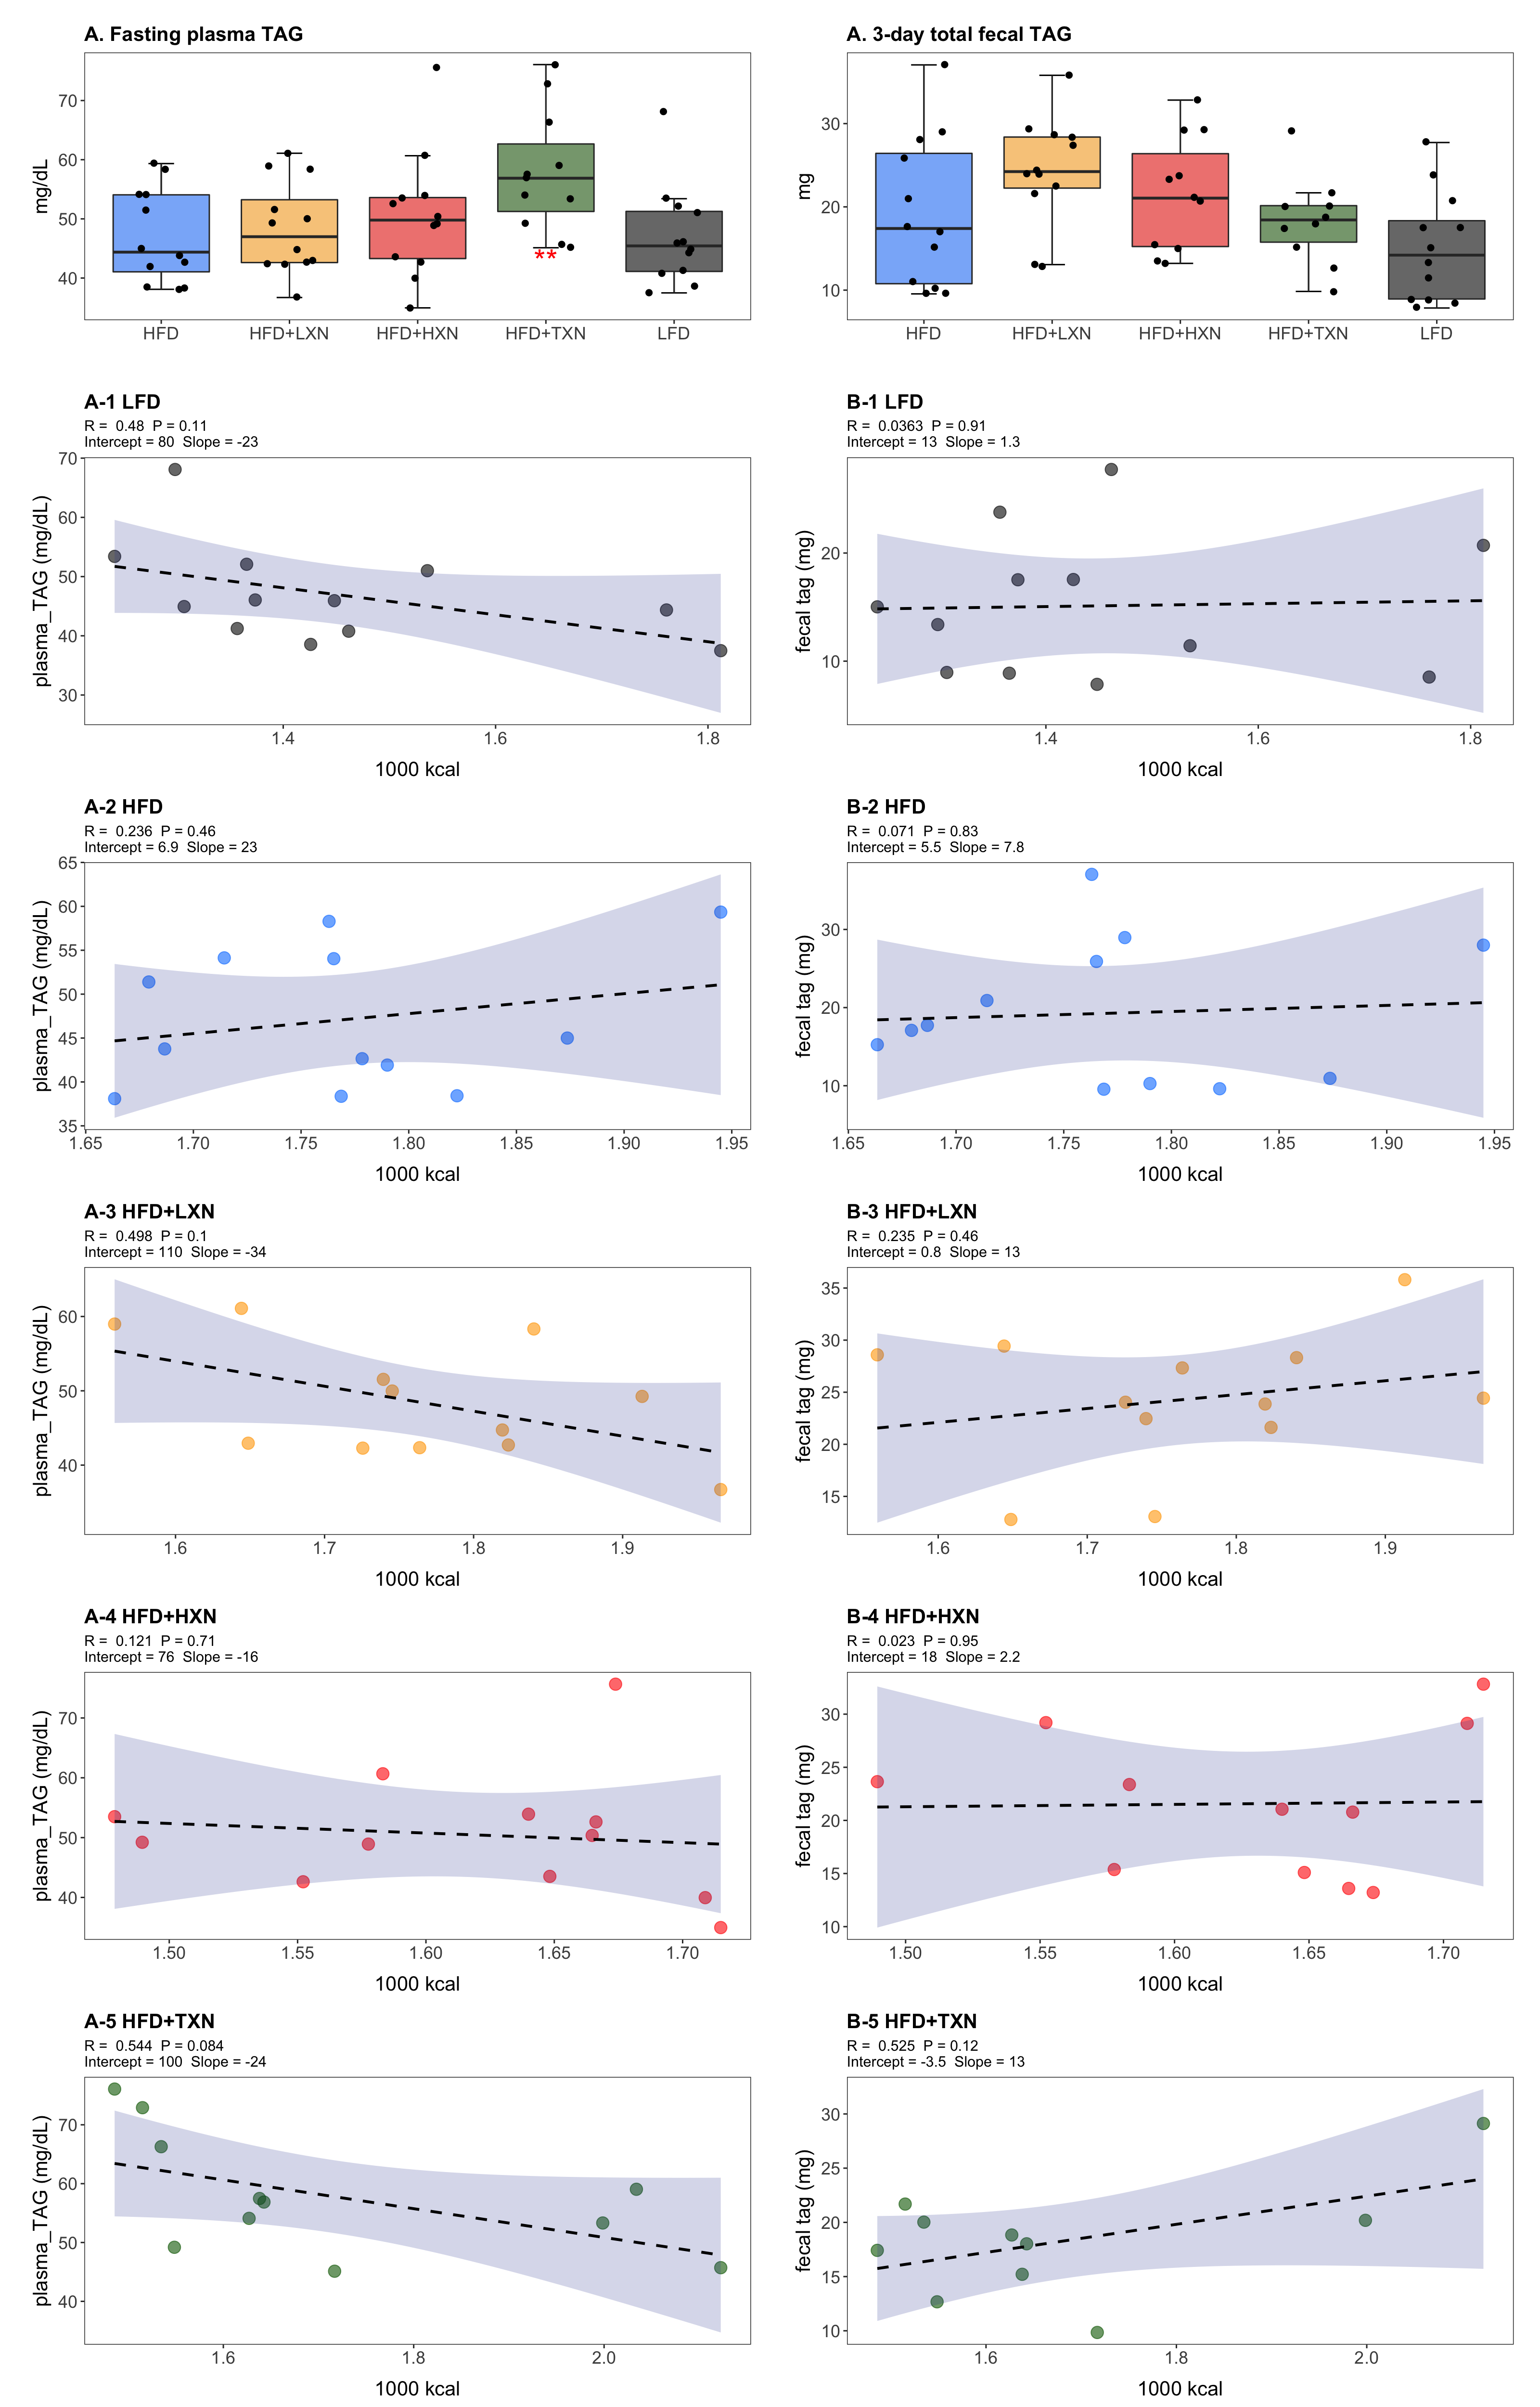

In [33]:
options(repr.plot.width = 16, repr.plot.height = 25, repr.plot.res = 200)
(figure4 <- wrap_plots(row1, row2, row3, row4, row5, row6, nrow=6))

In [35]:
#graph2pdf(figure4, "figure4.pdf", width = 16, height = 25)
#graph2svg(figure4, "figure4.svg", width = 16, height = 25)